In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import requests
import re
from datetime import datetime
import pandas as pd
import geopandas as gpd

In [3]:
from shapely.geometry import Point

In [4]:
import matplotlib.pyplot as plt

In [5]:
import contextily as cx

In [6]:
pd.set_option('display.max_colwidth', 100)

In [4]:
## Get the Data

# The National Observatory of Athens has an earthquake catalog; for each year there is a txt file with all the earthquakes in Greece

years = [2021, 2022]
noa_url = [f'https://www.gein.noa.gr/HTML/Noa_cat/CAT{year}.TXT' for year in years]
noa_url

['https://www.gein.noa.gr/HTML/Noa_cat/CAT2021.TXT',
 'https://www.gein.noa.gr/HTML/Noa_cat/CAT2022.TXT']

In [6]:
for url in noa_url:
    filename = f"Data/{url.split('/')[-1]}"
    with open(filename, mode='w') as f:
        try:
            f.write((response := requests.get(url)).text)
            response.status_code
        except Exception as e:
            print(e)
            print('Website currently not available')

1503489

200

1235289

200

In [7]:
# examine the data
with open('Data/CAT2022.TXT', 'r') as data:
    ll = data.readlines()
    # print(ll[:50])
    llt = ''.join(ll[:50])
    print(llt)

 DATE         TIME     LAT.   LONG.  DEPTH    MAGNITUDE            
                   (GMT)    (N)    (E)    (km)       (Local)
 2022 JAN  1   00 44 59.3 35.1732 25.3047    6         1.0
 2022 JAN  1   00 45 57.8 35.1077 25.2090   12         1.2
 2022 JAN  1   01 10 41.6 38.3437 22.0345    9         0.9
 2022 JAN  1   02 42 36.9 37.8625 23.0164   12         1.9
 2022 JAN  1   02 49 01.2 36.6385 21.4590   12         2.2
 2022 JAN  1   03 28 57.7 36.4517 21.7960    6         1.9
 2022 JAN  1   03 42 03.9 37.3114 20.5389   12         2.0
 2022 JAN  1   03 47 45.9 35.1787 25.3276    5         0.9
 2022 JAN  1   03 52 10.4 39.4972 20.6703    9         2.2
 2022 JAN  1   03 52 47.6 35.6168 27.2562   14         2.8
 2022 JAN  1   04 14 17.4 35.1448 25.3157   13         1.6
 2022 JAN  1   04 30 14.9 35.1759 25.3139    7         2.4
 2022 JAN  1   04 54 21.8 38.3611 22.2972   12         1.7
 2022 JAN  1   05 22 49.7 38.2814 23.3693   14         1.1
 2022 JAN  1   05 22 56.3 35.1494 25.2534   1

In [ ]:
# the text file of earthquakes contains 6 columns separated by space
# cleaning will require removing the empty rows and distinguishing the columns as not every space delinates one column

In [8]:
def to_date(text):
    date_re = re.compile(r'(\d{4}\s+[A-Z]{3}\s+\d{1,2})')
    dates =  date_re.findall(text)
    return [datetime.strptime(d, '%Y %b %d').strftime('%d/%m/%Y') for d in dates]

In [9]:
def to_time(text):
    time_re = re.compile(r'\d{2}\s{1}\d{2}\s{1}[\d.]+')
    times = time_re.findall(text)
    return [datetime.strptime(t, '%H %M %S.%f').strftime('%H:%M:%S.%f') for t in times]

In [10]:
def to_latitude(text):
    lat_re = re.compile(r'([\d.]+)(?=\s[\d.]+\s{2,4})', flags = re.MULTILINE)
    lats = lat_re.findall(text)
    return [float(lat) for lat in lats]

In [11]:
def to_longitude(text):
    lon_re = re.compile(r'([\d.]+)(?=\s{2,}\d+\s{2,}[\d.]+$)', flags = re.MULTILINE)
    lons = lon_re.findall(text)
    return [float(lon) for lon in lons]

In [12]:
def to_depth(text):
    depth_re = re.compile(r'(\d+)(?=\s{5,}[\d.])')
    depths = depth_re.findall(text)
    return [int(d) for d in depths]


In [13]:
def to_magnitude(text):
    magn_re = re.compile(r'([\d.]+)$', flags = re.MULTILINE)
    magns = magn_re.findall(text)
    return [float(m) for m in magns]

In [14]:
def create_points(lst):
    lon = to_longitude(''.join(lst))
    lat = to_latitude(''.join(lst))
    return [Point(lon[i], lat[i]) for i in range(len(lon))]

In [15]:
def text2df(filename):
    '''
    '''
    with open(filename, 'r', encoding='UTF-8') as f:
        lines = '\n'.join(f.readlines())
        d = {'Date': to_date(lines),
             'Time(GMT)': to_time(lines),
             'Depth(km)': to_depth(lines),
             'Magnitude(Local)': to_magnitude(lines),
             'geometry': create_points(lines)}
        return gpd.GeoDataFrame(d, crs="EPSG:4326")

In [16]:
# from text lines to pandas (Geo)DataFrame...
eques_gdf_2021 = text2df('Data/CAT2021.TXT')
eques_gdf_2022 = text2df('Data/CAT2022.TXT')

In [17]:
eques_gdf_2021.head()
eques_gdf_2021.tail()
print(f"rows:{eques_gdf_2021.shape[0]}, columns:{eques_gdf_2021.shape[1]}")

,Date,Time(GMT),Depth(km),Magnitude(Local),geometry
0,01/01/2021,00:38:24.300000,8,1.2,POINT (21.98320 38.38940)
1,01/01/2021,00:57:47.900000,8,0.8,POINT (22.02900 38.37480)
2,01/01/2021,01:09:25.700000,7,1.6,POINT (22.02900 38.36930)
3,01/01/2021,01:28:31.000000,17,2.1,POINT (21.15460 40.43110)
4,01/01/2021,01:53:23.600000,45,1.9,POINT (24.32830 34.95030)


,Date,Time(GMT),Depth(km),Magnitude(Local),geometry
25051,31/12/2021,22:55:36.600000,16,2.8,POINT (27.10240 36.45540)
25052,31/12/2021,23:03:08.800000,8,0.9,POINT (21.82850 38.34920)
25053,31/12/2021,23:31:57.500000,11,1.7,POINT (23.32350 38.75840)
25054,31/12/2021,23:36:13.500000,12,1.7,POINT (25.19210 35.08070)
25055,31/12/2021,23:36:34.000000,13,1.9,POINT (25.21680 35.08800)


rows:25056, columns:5


In [18]:
eques_gdf_2022.head()
eques_gdf_2022.tail()
print(f"rows:{eques_gdf_2021.shape[0]}, columns:{eques_gdf_2022.shape[1]}")

,Date,Time(GMT),Depth(km),Magnitude(Local),geometry
0,01/01/2022,00:44:59.300000,6,1.0,POINT (25.30470 35.17320)
1,01/01/2022,00:45:57.800000,12,1.2,POINT (25.20900 35.10770)
2,01/01/2022,01:10:41.600000,9,0.9,POINT (22.03450 38.34370)
3,01/01/2022,02:42:36.900000,12,1.9,POINT (23.01640 37.86250)
4,01/01/2022,02:49:01.200000,12,2.2,POINT (21.45900 36.63850)


,Date,Time(GMT),Depth(km),Magnitude(Local),geometry
20581,31/12/2022,23:14:29.100000,18,1.0,POINT (23.55610 38.63390)
20582,31/12/2022,23:16:03.500000,12,1.4,POINT (23.73090 41.24590)
20583,31/12/2022,23:16:06.100000,7,1.5,POINT (20.61490 39.68900)
20584,31/12/2022,23:54:03.500000,11,1.4,POINT (23.43520 41.75490)
20585,31/12/2022,23:57:32.700000,13,0.7,POINT (22.13650 38.27360)


rows:25056, columns:5


In [19]:
# combine earthquakes data frames
eques_gdf = pd.concat([eques_gdf_2021, eques_gdf_2022], ignore_index = True)
eques_gdf.shape

(45642, 5)

In [20]:
eques_wm = eques_gdf.to_crs(epsg = 3857)

In [30]:
# set the date as the dataframe index
eques_wm['Date'] = pd.to_datetime(eques_wm['Date'], dayfirst=True)
eques_wm = eques_wm.set_index('Date')

# separate column for month
eques_wm['Month'] = eques_wm.index.month_name()
eques_wm.head()

,Time(GMT),Depth(km),Magnitude(Local),geometry,Month
Date,,,,,
2021-01-01,00:38:24.300000,8,1.2,POINT (2447158.630 4634581.964),January
2021-01-01,00:57:47.900000,8,0.8,POINT (2452257.063 4632508.625),January
2021-01-01,01:09:25.700000,7,1.6,POINT (2452257.063 4631727.681),January
2021-01-01,01:28:31.000000,17,2.1,POINT (2354919.300 4928787.747),January
2021-01-01,01:53:23.600000,45,1.9,POINT (2708213.968 4157129.162),January


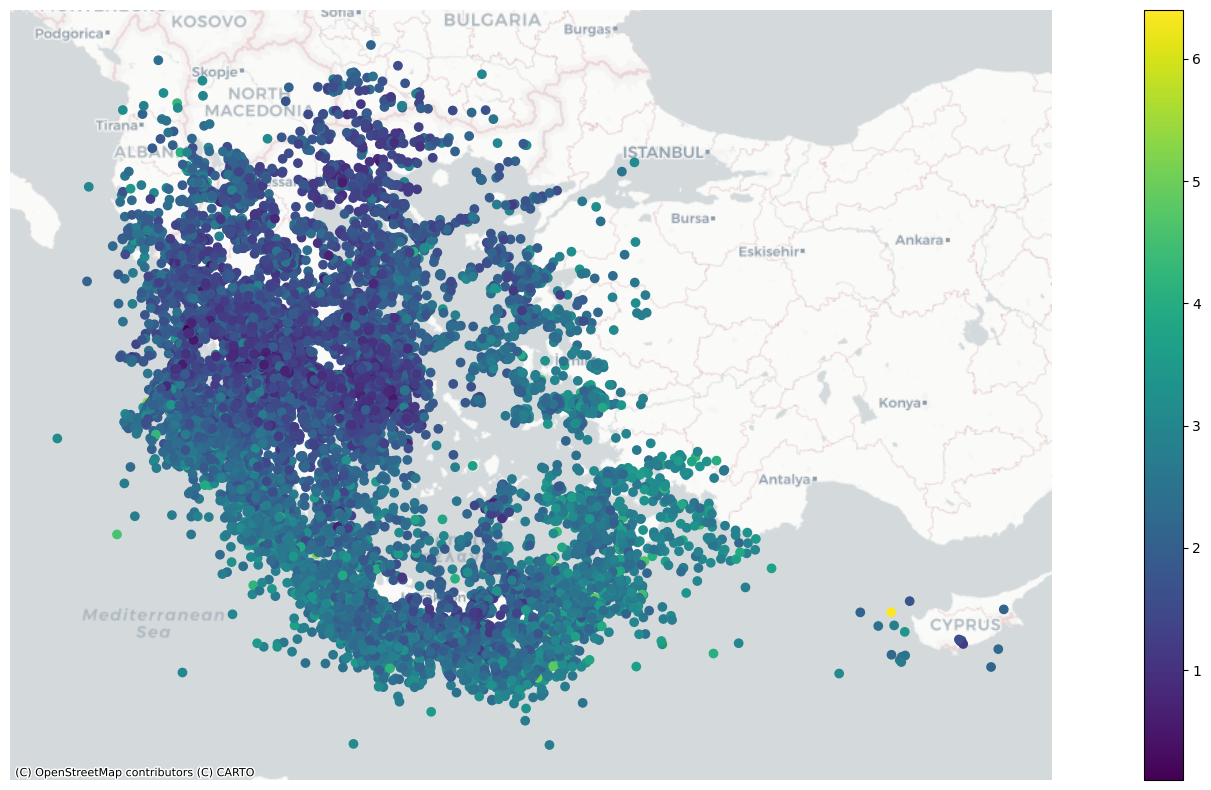

In [31]:
## plot the earthquakes and basemap

ax = eques_wm.plot(figsize=(24,10), column='Magnitude(Local)', legend=True)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off();

In [32]:
# mask will be used to clip the GeoDataFrame to the area of interest
mask = gpd.GeoSeries.from_file('Data/mask.geojson')
mask_wm = mask.to_crs(epsg=3857)

In [33]:
# clip the data to the mask extend
eques_wm_clip = gpd.clip(eques_wm, mask_wm)
eques_wm_clip.head()
eques_wm_clip.shape

,Time(GMT),Depth(km),Magnitude(Local),geometry,Month
Date,,,,,
2022-12-30,02:40:09.200000,10,1.2,POINT (2833470.659 4158487.381),December
2022-02-18,11:58:37.900000,5,1.1,POINT (2820880.424 4179084.716),February
2022-05-28,10:47:36.800000,9,1.9,POINT (2822617.009 4179220.799),May
2022-06-23,20:06:37.200000,12,2.6,POINT (2821492.682 4179343.275),June
2022-04-14,18:27:42.500000,15,1.4,POINT (2823986.238 4180023.723),April


(6981, 5)

In [34]:
# download a CartoDB basemap based on mask boundaries

w, s, e, n = mask_wm.total_bounds

# using the above coordinates download the basemap in tif format 
_ = cx.bounds2raster(w, s, e, n,
                    ll=False,
                    zoom=12,
                    path='Data/heraklion_positron.tif',
                    source=cx.providers.CartoDB.Positron
                    )

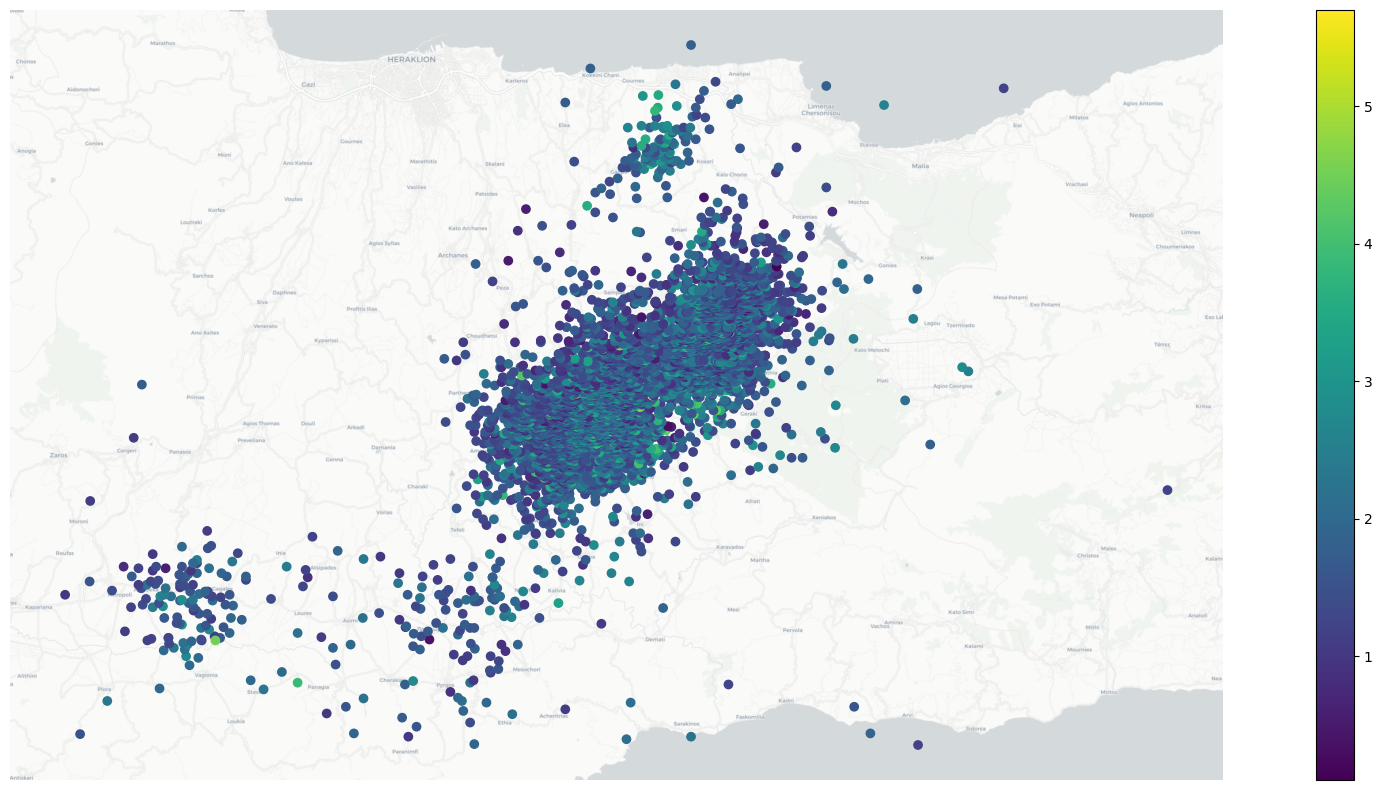

In [35]:
ax = eques_wm_clip.plot(figsize=(24,10), column = 'Magnitude(Local)', legend=True)
cx.add_basemap(ax, source = 'Data/heraklion_positron.tif')
ax.set_axis_off();